## End-to-End Pipeline to Classify News Articles

                                       Gaurav Singh
                                       UID:305353434

### Exploring the data

In [1004]:
# Importing libraries to be used in the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import contractions
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

import pickle
import umap
import umap.plot


In [1005]:
# Initializations
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

stopWords = set(stopwords.words('English'))

In [1006]:
# Loading the data
rawData = pd.read_csv('Project_1_dataset_01_01_2022.csv')

# Looking at raw data attributes
print("-------------Column names-------------\n \n", rawData.columns, '\n')

# Getting the unique leaf_label and root_label
print("-------------Unique leaf labels------------- \n", rawData['leaf_label'].unique(), '\n')
print("-------------Unique root labels------------- \n", rawData['root_label'].unique(), '\n')

print("Row samples: {}, features: {}, \n".format(rawData.shape[0], rawData.shape[1]))

print("-------------Viewing a few data points randomly-----------")
rawData.sample(5)


-------------Column names-------------
 
 Index(['Unnamed: 0', 'full_text', 'summary', 'keywords', 'publish_date',
       'authors', 'url', 'leaf_label', 'root_label'],
      dtype='object') 

-------------Unique leaf labels------------- 
 ['cricket' 'football' 'soccer' 'chess' '%22forest%20fire%22' 'flood'
 'earthquake' 'drought'] 

-------------Unique root labels------------- 
 ['sports' 'climate'] 

Row samples: 2072, features: 9, 

-------------Viewing a few data points randomly-----------


,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
1230,2151,"On Nov. 5, Rep. Pete Stauber voted no on Presi...","On Nov. 5, Rep. Pete Stauber voted no on Presi...","['money', 'life', 'health', 'support', 'strong...",NaN,['Ashlie Castaldo'],https://www.duluthnewstribune.com/opinion/colu...,%22forest%20fire%22,climate
210,407,"For Papua New Guinea, even advancing out of th...","For Papua New Guinea, even advancing out of th...","['guinea', 'oman', 'journey', 'papua', 'big', ...",2021-10-15 00:00:00,['Emaad Akhtar'],https://www.nytimes.com/2021/10/15/sports/cric...,cricket,sports
1595,3093,A 5.9 magnitude earthquake shook south-central...,A 5.9 magnitude earthquake shook south-central...,"['earthquake', 'alaska', 'immediate', 'miles',...",NaN,[],https://www.msn.com/en-us/news/us/magnitude-5-...,earthquake,climate
1317,3003,The Quad Cities saw a major flood in 1965. The...,The Quad Cities saw a major flood in 1965.\nNo...,"['davenport', 'plan', 'flood', 'improvements',...",2021-11-18 00:00:00,[],https://big1065.iheart.com/featured/mark-manue...,flood,climate
1426,2614,Cyberpunk 2077 and The Witcher creator CD Proj...,Cyberpunk 2077 and The Witcher creator CD Proj...,"['molasses', 'flood', 'projekt', 'indie', 'cd'...",2021-11-01 20:25:42+00:00,[],https://www.ign.com/articles/cd-projekt-red-ac...,flood,climate


Text(0, 0.5, 'Frequency of each root label')

<Figure size 432x288 with 0 Axes>

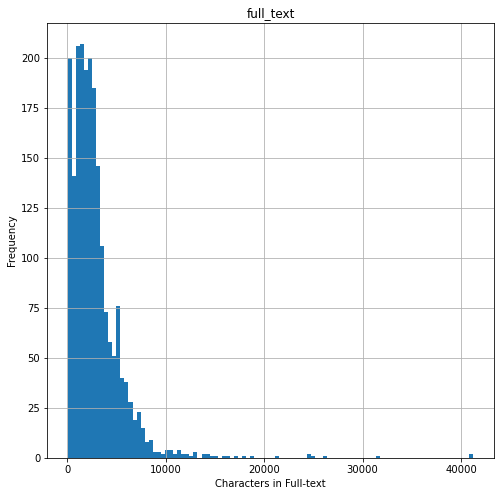

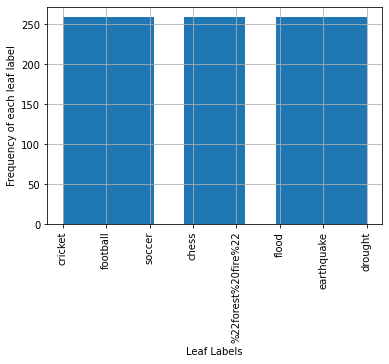

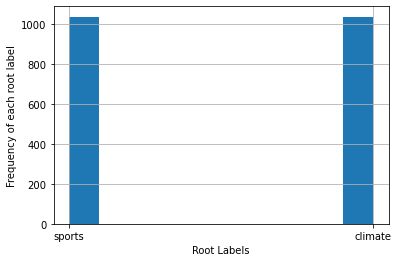

In [563]:
plt.figure()
pd.DataFrame(rawData['full_text'].apply(lambda x: len(x))).hist(bins=100, figsize= (8, 8))
plt.xlabel("Characters in Full-text")
plt.ylabel("Frequency")


plt.figure()
rawData['leaf_label'].hist(xrot=90)
plt.xlabel("Leaf Labels")
plt.ylabel("Frequency of each leaf label")


plt.figure()
rawData['root_label'].hist()
plt.xlabel("Root Labels")
plt.ylabel("Frequency of each root label")

## Question 1
<b>(a).</b>

    Row samples: 2072, features: 9

<b>(b)</b>. All three histograms are plotted in above cell.

<b>(c)</b>. For raw 'full-text' feature, we can see that there are a some outliers having a very large number of characters and quite a lot having extremely small number of characters. The data distribution of number of articles vs no. of characters can be roughly seen as a Gaussian Distribution.

For the histogram <b>No. of articles vs Leaf labels</b>, we can see that samples are evenly distributed into each leaf label (8 total labels) category with each label having around ~259 samples each.

For the histogram <b>No. of articles vs Root labels</b>, we can see that samples are evenly distributed into each root label (sports and climate) with each label having around ~ 1036 samples each.

In [564]:
# Seeding the random number generator

np.random.seed(42)
random.seed(42)

### Binary Classification of articles using only the feature "full_text"

In [565]:
#  Splitting the data into train and test with test_size as 20%
train, test = train_test_split(rawData, test_size=0.2)
print("--------- Train data Size: {}, Test data Size: {} ---------".format(len(train), len(test)))

--------- Train data Size: 1657, Test data Size: 415 ---------


## Question 2

<b>Training dataset size</b>: 1657

<b>Test dataset size</b>: 415


### Feature extraction

The feature which we are going to use is "full_text" which is neither cleaned nor it can be used to perform computations on it. We need some numerical representation of such data to perform classification.

In [1007]:
#  Function to clean the raw HTML text

"""
- HTML artifacts removal
- Links removal
- quotes removal
- Special characters removal
- Extra spaces removal
- Changing the short forms to full forms using contractions
- Punctuations removal
- Changing all text to lower case
"""

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

In [663]:
# Function to get the part of speech tag for wordnet lemmatizer using the nltk tags
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOUN

# Function to lemmatize each sentence, along with stripping extra spaces, full stops and numbers.
def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    posTags = nltk.pos_tag(tokens)
    tags = [get_pos_tags(w[1]) for w in posTags]
    lemmas = [lemmatizer.lemmatize(tokens[i], tags[i]) for i in range(0, len(tokens))]
    lemmas = ' '.join(lemmas)
    lemmas = re.sub(r'\w*\d\w*', '', lemmas)
    lemmas = re.sub('[.]', '', lemmas)
    lemmas = re.sub(' +', ' ', lemmas).strip()
    return lemmas

#  Function to stem the sentence along with stripping extra spaces, full stops and numbers.
def stemmer(text):
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(tokens[i]) for i in range(0, len(tokens))]
    stems = ' '.join(stems)
    stems = re.sub(r'\w*\d\w*', '', stems)
    stems = re.sub('[.]', '', stems)
    stems = re.sub(' +', ' ', stems).strip()
    return stems

# Whole preprocessing pipeline with lemmatization
def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Whole preprocessing pipeling with stemming
def preprocessStem(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing pipeline with cleaning but without any compression
def preprocessNoCompress(sample):
    sample = clean(sample)
    return sample


# Preprocessing with lemmatization but no cleaning
def preprocessNC(sample):
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing with stemming but no cleaning
def preprocessStemNC(sample):
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing without any compression or cleaning
def preprocessNoCompressNC(sample):
    return sample

### Pipeline to extract features using CountVectorizer and TFIDFTransformer

In this part we are using full preprocessing using Lemmatization and cleaning, with stop words removal and min_df as 3 to restrict the vocabulary from growing too much.

In [664]:
# Feature Extraction using CountVectorizer and TF-IDF transformation using Pipeline.
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(train['full_text'])

In [569]:
#  TF-IDF processed train and test matrices.
train_tfidf = featurePipeline.transform(train['full_text'])
test_tfidf = featurePipeline.transform(test['full_text'])

print("--------- Training data TF-IDF Matrix size: {}--------".format(train_tfidf.shape))
print("--------- Testing data TF-IDF Matrix size: {}--------".format(test_tfidf.shape))

--------- Training data TF-IDF Matrix size: (1657, 9865)--------
--------- Testing data TF-IDF Matrix size: (415, 9865)--------


In [570]:
# Seeing some IDF values of words in training corpus
idf_Df = pd.DataFrame(pipe['tfidf'].idf_, index=pipe['count'].get_feature_names(),columns=["IDF_weights"])
idf_Df.sort_values(by=["IDF_weights"], ascending=False).sample(10)

,IDF_weights
dean,6.015472
occupy,5.417635
swim,6.803929
raging,7.027073
defensive,4.606705
bundesliga,6.803929
revenue,4.802449
brigade,6.216143
sandbag,6.803929
resonant,7.027073


In [571]:
# Getting TF-IDF vector representations of some of the documents in training corpus
trialData = train['full_text'].sample(5)
tfidf_trialData = pipe.transform(trialData)

## Question 3

<b>(a)</b>. 
<b>Pros of Lemmatization</b>:
1. Lemmatization tries to understand the context in which the word is used. Based on the context the word's lemma can vary which is very useful if differentiating in the context of two sentences having same words. 

2. Lemmatization can capture the semantic meaning of words in which it is used in a sentence.

<b>Cons of Lemmatization</b>:

1. Lemmatization requires a large corpus and well formed dictionaries to get the lemma of a word or change it based on the context and on the form(verb, noun, adverb etc) in which it is used in sentence. Stemming just uses the word and tries to find it's stem using language based rules by trimming from front or back of word.

2. Lemmatization process is slower in run-time compared to stemming.


<b>(b)</b>.
As we increase the min_df (minimum document frequency) the tf-idf size(columns) reduces since generally not all words are equally likely to be present in a corpus and thus words with lower frequencies (below min_df) in corpus are dropped and thus the representation vector for each sample also reduces.

<b>(c)</b>. </br>
It's better to remove stopwords before lemmatizing since the lemmatization process can change the stopwords and they might not be present in the stopwords list being used and thus are kept in the corpus as features although they don't make much sense.
However if the lemmatizer is some Neural Networks based lemmatizer/ model which takes in a complete sentence to get the vector representations of the words using the context in which it is used like Word2Vec or GLoVE then removal of stopwords can make a difference in the way these embeddings occupy the vector space since stopwords do contribute to some context and semantic meaning to the whole sentence.

Punctuations should be removed before lemmatizing because most of the lemmatizers use a list of words as input and punctutations don't fall into a word category so they are quite useless. Some punctuations should be preprocessed and removed earlier like apostrophes in words like don't etc. This can be done via contractions.

Numbers can be removed before or after lemmatizing since they are just numerals and dont really have a lemma. Basically their form is unaltered even after lemmatizing. 

<b>(d)</b>.
Training data TF-IDF Matrix size: (1657, 9865)
Testing data TF-IDF Matrix size: (415, 9865)

No. of columns: (k * 10^3) where k ~ 9.8

### Dimensionality Reduction using LSI and NMF

We are going to use two methods to reduce the high dimensional feature space to low dimensional space so that our models can perform well on them given the training examples are not too much thus having high dimensional feature space can lead to bad performance of classifiers due to curse of dimensionality.

In [1008]:
"""
Functions to get the trained SVD and NMF model
"""

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

## Question 4

- Plotting the explained variance ratio across different K
- Computing the reconstruction Residual error while using LSI and NMF using the same K = 50
- Reconstruction error is computed on training data with K = 50

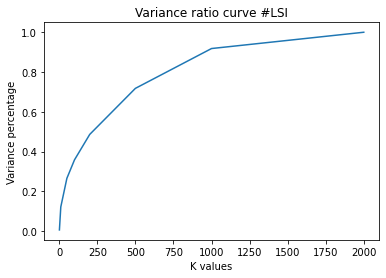

In [574]:
# Plotting variance graph
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
variance_ratio = []
reconstructionErrors = []

for i in range(0, len(k_values)):
    SVD = getSVD(k_values[i], train_tfidf)
    variance_ratio.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(train_tfidf)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrors.append(np.linalg.norm((train_tfidf.toarray() - reconstruct), 'fro') ** 2)
    
plt.plot(k_values, variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI")
plt.show()

In [575]:
# Fitting NMF for k = 50
k = 50
NMFdecomp = getNMF(k, train_tfidf)

In [576]:
# Reconstruction Errors
reconstructedLSIError = reconstructionErrors[2]
reconstructedNMFError = (NMFdecomp.reconstruction_err_)**2

print("---------- Reconstruction residual MSE error for LSI:: {} -----------".format(reconstructedLSIError))
print("---------- Reconstruction residual MSE error for NMF:: {} -----------".format(reconstructedNMFError))

---------- Reconstruction residual MSE error for LSI:: 1177.8659302458702 -----------
---------- Reconstruction residual MSE error for NMF:: 1197.1490559991569 -----------


## Question 4

<b>(a).</b>

The variance ratio plot for LSI looks like a transient curve which increases exponentially when K is small and then saturates. It's a concave curve.
The plot's concavity suggests that projections along the initial singular vectors which correspond to largest eigen values capture most of the variance and important data rest have less information about data and contain more noise. The graph shows that first 250 principal singular vectors capture around 60% of variance, and principal 1000 singular vectors capture around 92-95% of variance in training data.

<b>(b).</b>

<b>Reconstruction residual MSE error for LSI </b>:: 1177.8659302458702 </br>
<b>Reconstruction residual MSE error for NMF </b>:: 1197.1490559991569

Reconstruction residual MSE error for LSI is smaller compared to that from NMF.

NMF works on determining the important features that best represent the data. Like Given a face, NMF will try to get important features which comprise the face. Thus overall NMF is really not trying to create the original data but trying to find the <b>important features</b> which then can be put together to get the whole data and thus it makes sense as to why the reconstruction error is a bit high for NMF. 

For LSI, it works on projecting data to eigen vectors which capture most variance i.e they try to retain most of the data. So LSI's aim to <b>get back the original data</b> which is evident from the examples that when images are projected onto eigen vectors they somewhat resemble the original image and stacking such multiple images of projections.
There LSI performs better on reconstructing data better.

Also NMF is sensitive to initialization and thus can be a reason why it is not able to decompose a matrix better whereas LSI doesn't depend on anything like this.

LSI is uses transformation of original matrix whereas NMF is an approximation method giving two matrices which intuitively represent important features of data and weights corresponding to them which shows why NMF reconstruction is a bit high. Transformations preserve data better.

## Binary Classification with choice of K

Choosing K to be 500 since it captures around 80% of variance also the number of data points then are almost 4 times to that of number of features hence somewhat less curse of diemnsionality.

### Using Support Vector Machines

- Training two linear SVM one with hard margin and one with soft margin.
- Evaluation of their performances

In [577]:
k_feat = 500
train_labels = np.array((train['root_label'] == 'climate').astype('int'))
test_labels = np.array((test['root_label'] == 'climate').astype('int'))

SVDK500 = getSVD(k_feat, train_tfidf)
trainDataK500 = SVDK500.transform(train_tfidf)
testDataK500 = SVDK500.transform(test_tfidf)

In [578]:
#Hard Linear SVM
HardSVMModel = svm.SVC(kernel='linear', C = 1000)
HardSVMModel.fit(trainDataK500, train_labels)
predictionsHard = HardSVMModel.predict(testDataK500)

# Gamma = 100000
GammaSVMModel = svm.SVC(kernel='linear', C = 100000)
GammaSVMModel.fit(trainDataK500, train_labels)
predictionsGamma = GammaSVMModel.predict(testDataK500)

#Soft Linear SVM
SoftSVMModel = svm.SVC(kernel='linear', C = 0.0001)
SoftSVMModel.fit(trainDataK500, train_labels)
predictionsSoft = SoftSVMModel.predict(testDataK500)

In [1036]:
def getScores(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / len(y_true)
    precision = tp/ (tp + fp)
    recall = (tp) / (tp + fn)
    f1 = 2*precision*recall/(precision + recall)
    
    return {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svmScores = {
    'HardSMV': {
        'climate': {
            'scores': getScores(test_labels, predictionsHard)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'HighGammaSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsGamma)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'SoftSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsSoft)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    }
}

In [580]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

In [1037]:
gammas = np.linspace(-3,6,10)
bestGamma = -1
minError = np.infty
bestSVM = None
for gamma in gammas:
    SVMk = svm.SVC(kernel='linear', C=(10**gamma))
    err = avgKFoldError(SVMk, trainDataK500, train_labels)
    print(err, SVMk)
    if err <= minError:
        minError = err
        bestGamma = 10**gamma
        bestSVM = SVMk

# Training best SVM
bestSVM.fit(trainDataK500, train_labels)
bestSVMPred = bestSVM.predict(testDataK500)

scores = getScores(test_labels, bestSVMPred)

170.4 SVC(C=0.001, kernel='linear')
170.4 SVC(C=0.01, kernel='linear')
16.6 SVC(C=0.1, kernel='linear')
12.0 SVC(kernel='linear')
15.4 SVC(C=10.0, kernel='linear')
16.6 SVC(C=100.0, kernel='linear')
16.6 SVC(C=1000.0, kernel='linear')
16.6 SVC(C=10000.0, kernel='linear')
16.6 SVC(C=100000.0, kernel='linear')
16.6 SVC(C=1000000.0, kernel='linear')


## Question 5

Scores for Hard SVM Model: SVC(C=1000, kernel='linear')

Accuracy:  0.9783132530120482
Precision:  0.9949748743718593
Recall Score:  0.9611650485436893
F1 Score:  0.9777777777777776


Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')

Accuracy:  0.9783132530120482
Precision:  0.9949748743718593
Recall Score:  0.9611650485436893
F1 Score:  0.9777777777777776


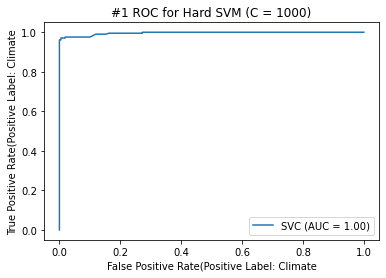

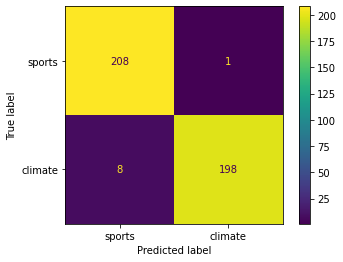

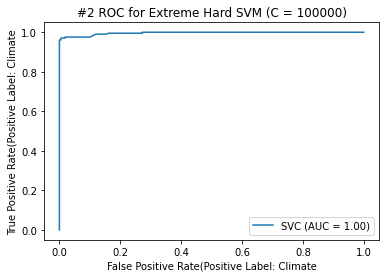

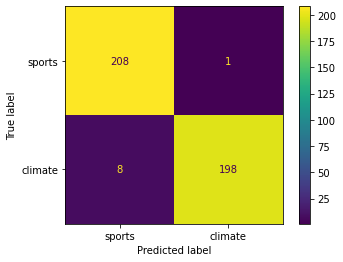

In [1033]:
# Plotting ROC curves and scores for all SVMs
print("Scores for Hard SVM Model: {}\n".format(HardSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsHard)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsHard)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsHard)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsHard)['f1'])

print("\n\nScores for Extreme Hard Classifier: {}\n".format(GammaSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsGamma)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsGamma)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsGamma)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsGamma)['f1'])

metrics.plot_roc_curve(HardSVMModel,testDataK500, test_labels)
plt.title("#1 ROC for Hard SVM (C = 1000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

plot_confusion_matrix(HardSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])

metrics.plot_roc_curve(GammaSVMModel,testDataK500, test_labels)

plt.title("#2 ROC for Extreme Hard SVM (C = 100000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")

plt.show()

plot_confusion_matrix(GammaSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')

Accuracy:  0.4963855421686747
Precision:  0.4963855421686747
Recall Score:  1.0
F1 Score:  0.6634460547504025


Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')

Accuracy:  0.9783132530120482
Precision:  1.0
Recall Score:  0.9563106796116505
F1 Score:  0.9776674937965261


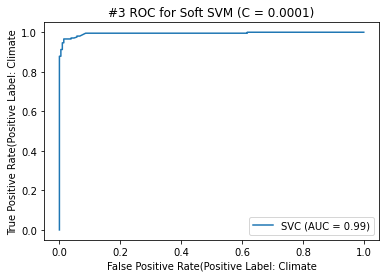

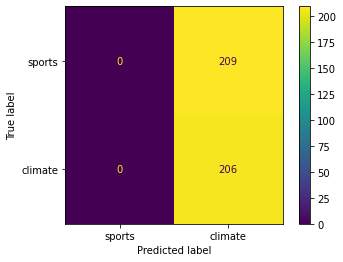

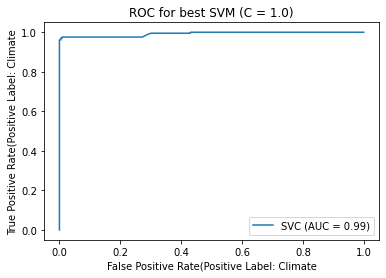

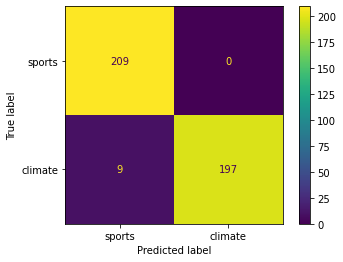

In [1035]:
print("Scores for Soft SVM Model: {}\n".format(SoftSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsSoft)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsSoft)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsSoft)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsSoft)['f1'])

print("\n\nScores for Best SVM Classifier after 5-Fold cross validation: {}\n".format(bestSVM))
print("Accuracy: ", getScores(test_labels, bestSVMPred)['accuracy'])
print("Precision: ", getScores(test_labels, bestSVMPred)['precision'])
print("Recall Score: ", getScores(test_labels, bestSVMPred)['recall'])
print("F1 Score: ", getScores(test_labels, bestSVMPred)['f1'])

metrics.plot_roc_curve(SoftSVMModel,testDataK500, test_labels)
plt.title("#3 ROC for Soft SVM (C = 0.0001)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()
plot_confusion_matrix(SoftSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(bestSVM, testDataK500, test_labels)
plt.title("ROC for best SVM (C = {})".format(bestGamma))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

plot_confusion_matrix(bestSVM, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

<b>(a)</b></br>
From above account by looking at the Metrics of Linear SVM with gamma = 0.0001 and gamma = 1000. 
Hard SVM with gamma = 1000 performs better.
This is because it shows high accuracy of about 97.83% on test data with about 1 False Positive and 8 False Negatives compared to Soft margin SVM which has about 49.63% accuracy on test data set and has a very poor precision(0.49) and F-1(0.66) score.

For extreme hard margin SVM with gamma = 100000, we see the results are very close to that of gamma = 1000 which indicates that the data has a very large margin and is quite well separable and thus very rare miclassifications hapenning as such.

<b>Confusion matrices and ROC Curves</b> for all classfiers i.e. for gamma = 1000, gamma = 0.0001 and gamma = 100000 are plotted above.
Rest metrics are given as below:

<b>Scores for Hard SVM Model: SVC(C=1000, kernel='linear')</b>

<b>Accuracy</b>:  0.9783132530120482,     <b>Precision</b>:  0.9949748743718593 </br>
<b>Recall Score</b>:  0.9611650485436893, <b>F1 Score</b>:  0.9777777777777776


<b>Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')</b>

<b>Accuracy</b>:  0.9783132530120482,      <b>Precision</b>:  0.9949748743718593 </br>
<b>Recall Score</b>:  0.9611650485436893,  <b>F1 Score</b>:  0.9777777777777776

<b>Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')</b>

<b>Accuracy</b>:  0.4963855421686747,      <b>Precision</b>:  0.4963855421686747 </br>
<b>Recall Score</b>:  1.0,                 <b>F1 Score</b>:  0.6634460547504025


<b>(b)</b></br>
The soft SVM with a very low penalty = 0.0001 is performing very poorly with low precision and accuracy. This is because since the penalty of misclassification is very low, all the data points are classified as Climate(true) as seen from above confusion matrix. All sports articles as classified as climate.

For the ROC curve of Soft SVM we see that it has the least area under the curve compared to all other SVM's. It looks like a perfect ROC curve having high AUC but we can't just rely on ROC Curve. The threshold within which it operates well is very low.

<b>(c)</b></br>
Using 5-Fold Cross Validation, the best value of gamma = C = 1.0, with average number of missclassifications per fold = 12.
Its confusion matrix and ROC curves are plotted above.

<b>Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')</b>

<b>Accuracy</b>:  0.9783132530120482,      <b>Precision</b>:  1.0 </br>
<b>Recall Score</b>:  0.9563106796116505   <b>F1 Score</b>:  0.9776674937965261

## Evaluation of Logistic Classifier

In [1045]:
# Logistic classifier
# Setting C to be high thus making regularization term ~0
logisticNoReg = LogisticRegression(random_state=42, C=100000, max_iter=5000).fit(trainDataK500, train_labels)
logisticNoRegPred = logisticNoReg.predict(testDataK500)
logisticNoRegScores = getScores(test_labels, logisticNoRegPred)

Avg. no. of misclassification:  166.0 LogisticRegression(C=0.0001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  166.0 LogisticRegression(C=0.001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  166.0 LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  31.0 LogisticRegression(C=0.1, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  15.2 LogisticRegression(max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  11.8 LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  12.0 LogisticRegression(C=100.0, max_iter=5000, penalty='l1', random_state=42

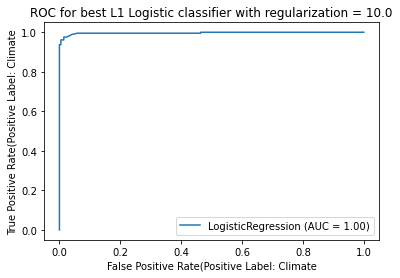

Avg. no. of misclassification:  57.2 LogisticRegression(C=0.0001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  44.2 LogisticRegression(C=0.001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  19.4 LogisticRegression(C=0.01, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  16.2 LogisticRegression(C=0.1, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  11.2 LogisticRegression(max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  10.6 LogisticRegression(C=10.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  12.8 LogisticRegression(C=100.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  14.4 LogisticRegression(C=1000.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  14.8 LogisticRegression(C=10000.0, max_iter

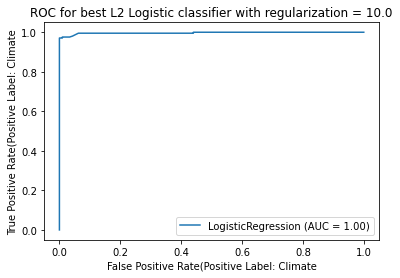

In [654]:
# Finding best regularization parameter for both L1 and L2 regularization for Logistic classifier
logRegs = np.linspace(-4,4,9)
bestRegL1 = -1
minL1Error = np.infty
bestL1Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=10**reg, max_iter=5000)
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL1Error:
        minL1Error = err
        bestRegL1 = 10**reg
        bestL1Model = clfLog

# Training best L1 Logistic classifier
bestL1Model.fit(trainDataK500, train_labels)
bestL1Pred = bestL1Model.predict(testDataK500)

L1scores = getScores(test_labels, bestL1Pred)
print("\n------------Metrics for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
print(L1scores)

metrics.plot_roc_curve(bestL1Model, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


bestRegL2 = -1
minL2Error = np.infty
bestL2Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l2', random_state=42, C=10**reg, max_iter=5000, solver='liblinear')
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL2Error:
        minL2Error = err
        bestRegL2 = 10**reg
        bestL2Model = clfLog

# Training best L2 Logistic classifier
bestL2Model.fit(trainDataK500, train_labels)
bestL2Pred = bestL2Model.predict(testDataK500)

L2scores = getScores(test_labels, bestL2Pred)
print("\n------------Metrics for best L2 Logistic classifier with regularization = {}".format(bestRegL1))
print(L2scores)

metrics.plot_roc_curve(bestL2Model, testDataK500, test_labels)
plt.title("ROC for best L2 Logistic classifier with regularization = {}".format(bestRegL2))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

## Question 6


Scores for Non regularized Logistic Classifier : LogisticRegression(C=100000, max_iter=5000, random_state=42)

Accuracy:  0.983132530120482
Precision:  1.0
Recall Score:  0.9660194174757282
F1 Score:  0.9827160493827161


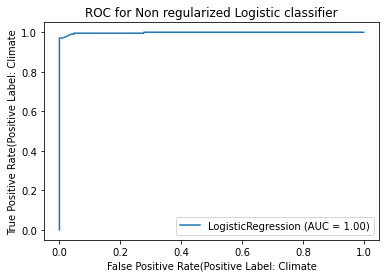

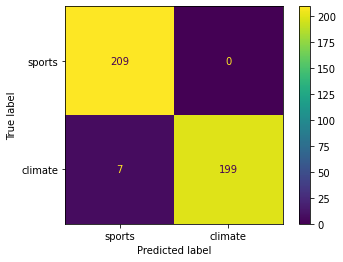


Scores for Non regularized Logistic Classifier : LogisticRegression(C=100000, max_iter=5000, random_state=42)

Accuracy:  0.983132530120482
Precision:  1.0
Recall Score:  0.9660194174757282
F1 Score:  0.9827160493827161


Scores for Best L1 regularized Classifier details : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9759036144578314
Precision:  0.9851485148514851
Recall Score:  0.9660194174757282
F1 Score:  0.9754901960784313


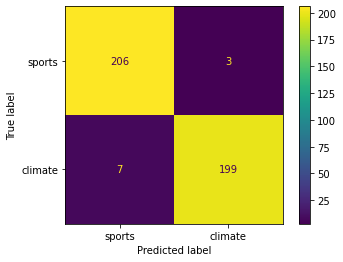



Scores for Best L2 regularized Classifier details : LogisticRegression(C=10.0, max_iter=5000, random_state=42, solver='liblinear')

Accuracy:  0.983132530120482
Precision:  1.0
Recall Score:  0.9660194174757282
F1 Score:  0.9827160493827161


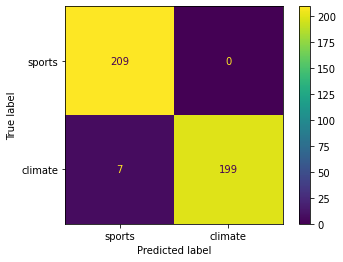

In [1044]:
print("\nScores for Non regularized Logistic Classifier : {}\n".format(logisticNoReg))
print("Accuracy: ", getScores(test_labels, logisticNoRegPred)['accuracy'])
print("Precision: ", getScores(test_labels, logisticNoRegPred)['precision'])
print("Recall Score: ", getScores(test_labels, logisticNoRegPred)['recall'])
print("F1 Score: ", getScores(test_labels, logisticNoRegPred)['f1'])

metrics.plot_roc_curve(logisticNoReg,testDataK500, test_labels)
plt.title("ROC for Non regularized Logistic classifier")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

plot_confusion_matrix(logisticNoReg, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#  Comparison of three Logistic Classifiers
print("\nScores for Non regularized Logistic Classifier : {}\n".format(logisticNoReg))
print("Accuracy: ", getScores(test_labels, logisticNoRegPred)['accuracy'])
print("Precision: ", getScores(test_labels, logisticNoRegPred)['precision'])
print("Recall Score: ", getScores(test_labels, logisticNoRegPred)['recall'])
print("F1 Score: ", getScores(test_labels, logisticNoRegPred)['f1'])

print("\n\nScores for Best L1 regularized Classifier details : {}\n".format(bestL1Model))
print("Accuracy: ", L1scores['accuracy'])
print("Precision: ", L1scores['precision'])
print("Recall Score: ", L1scores['recall'])
print("F1 Score: ", L1scores['f1'])

plot_confusion_matrix(bestL1Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

print("\n\nScores for Best L2 regularized Classifier details : {}\n".format(bestL2Model))
print("Accuracy: ", L2scores['accuracy'])
print("Precision: ", L2scores['precision'])
print("Recall Score: ", L2scores['recall'])
print("F1 Score: ", L2scores['f1'])

plot_confusion_matrix(bestL2Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()



<b>a).</b></br>
Training a logistic classfier without regularization. </br>
Scikit learn logistic classifier by default uses regularization which can be suppressed by using a large C.
I have used C to be 100000 which has same effect as inverse of regularization and thus we can consider the classifier to be without regularization.

The ROC curve and condusion matrix for <b>Logistic Regression without regularization</b> are shown above.
The scores for the same on testing set are as follows: 

<b>Accuracy</b>:  0.983132530120482         <b>Precision</b>:  1.0 </br>
<b>Recall Score</b>:  0.9660194174757282    <b>F1 Score<b>:  0.9827160493827161
    
<b>b).</b><br>
<b>I have optimized the classifier for best C value which is inverse of regularization strength and since the range in which, it was asked to find the regularization[10^-4 to 10^4] was symmetric, the results wont change.</b> </br>
The optimal L1 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: <b>C = 10.0 which is equal to 0.1 regularization strength</b>. Solver = 'liblinear'
    
Scores for best L1 Regularized classifier:</br>
<b>Accuracy</b>:  0.9759036144578314 <b>Precision</b>:  0.9851485148514851 </br>
<b>Recall Score</b>:  0.9660194174757282F1 <b>F1 Score<b>:  0.9754901960784313
    

The optimal L2 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: <b>C = 10.0 which is equal to 0.1 regularization strength</b>. Solver = 'liblinear'

Scores for best L1 Regularized classifier:<br>
<b>Accuracy</b>:  0.983132530120482 <b>Precision</b>:  1.0 <br>
<b>Recall Score</b>:  0.9660194174757282 <b>F1 Score<b>:  0.9827160493827161
    
    
<b>c).</b><br>
The avg. number of miclassifications for l1 penalty with change in regularization parameter are given below:
    
Avg. no. of misclassification:  166.0 , regularization parameter = 10000
    
Avg. no. of misclassification:  166.0 , regularization parameter = 1000
    
Avg. no. of misclassification:  166.0 , regularization parameter = 100
    
Avg. no. of misclassification:  31.0 , regularization parameter = 10
    
Avg. no. of misclassification:  15.2 , regularization parameter = 1
    
Avg. no. of misclassification:  11.8 , regularization parameter = 0.1
    
Avg. no. of misclassification:  12.0 , regularization parameter = 0.01
    
Avg. no. of misclassification:  12.8 , regularization parameter = 0.001
    
Avg. no. of misclassification:  19.0  , regularization parameter = 0.0001
    
    
The avg. number of miclassifications for l2 penalty with change in regularization parameter are given below:
    
Avg. no. of misclassification:  57.2 , regularization parameter = 10000
    
Avg. no. of misclassification:  44.2 , regularization parameter = 1000
    
Avg. no. of misclassification:  19.4 , regularization parameter = 100
    
Avg. no. of misclassification:  16.2 , regularization parameter = 10
    
Avg. no. of misclassification:  11.2 , regularization parameter = 1
    
Avg. no. of misclassification:  10.6, regularization parameter = 0.1
    
Avg. no. of misclassification:  12.8 , regularization parameter = 0.01
    
Avg. no. of misclassification:  14.4 , regularization parameter = 0.001
    
Avg. no. of misclassification:  14.8, regularization parameter = 0.0001
    

From the above account we can see that the test error first decreases with the increase in regularization parameter from 0.0001 till 1 where it achieves its minima and then the test error increases with the increase in regularization parameter.
    
<b>Effect of regularization on the learned coefficients</b><br>
As the regularization parameter is increased the effect of features is reduced i.e. the effect of features is somewhat reduced and as we keep on increasing the regularization parameter, the model becomes too relax and starts to perform worse due to high underfitting since features just represent a striaght line with zero slope.
    
Different types of regularization are used, to tackle different types of data and to handle the results. L2 regularization is used when the data is clean, there are not many outliers in the data, since L2 penalizes the errors more, also L2 is used when all features are important to consider since L2 regularization doest help in feature selection. 
    
L1 regularization is used when one is unsure of the important features as using L1 reg. unimportant feature's weights are set to 0 where in L2 reg. this only asymptotically reaches to 0. Also L1 reg. can be used when there are outliers in data.
    
    
<b>d).</b><br>
Logistic regression and SVM are quite similar in the terms that both are classifying the data using a linear decision boundary. The difference is that logistic regression uses a probability based approach whereas SVM uses a geometrical/ deterministic approach. Logistic regression tries to find the odds in favour of a class, SVM tries to find a decision boundary/ separating hyperplane which maximizes the distance between the separating hyperplace. Their performances differ because of the fact that SVM uses concept of margins. When the data is completely linearly separable the results are very much comparable for both but when its' not the case, the gamma parameter in SVM's decides the difference in results between Logistic and SVM. 
    
Also SVM's perform better when the data has a lot number of features then the training samples, thats because it used the Kernelization method to overcome the curse of dimensionality but this is not the case for Logistic Regression. Also we can fit non linear decision boundaries with SVM but the same cant be done with LR.
    
With the above data in hand, Logistic Regression seems to perform better having 98.3 % accuracy compared to that of 97.6% of SVM's.


In [1046]:
# Gaussian Naive Bayes Model
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(trainDataK500, train_labels)
gaussianNBPred = GaussianNBModel.predict(testDataK500)
gaussianNBScores = getScores(test_labels, gaussianNBPred)

Scores for Gaussian Naive Bayes Classifier : GaussianNB()

Accuracy:  0.8963855421686747
Precision:  0.8438818565400844
Recall Score:  0.970873786407767
F1 Score:  0.9029345372460497


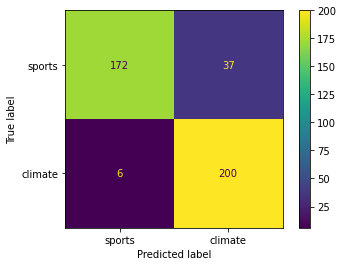

In [1047]:
print("Scores for Gaussian Naive Bayes Classifier : {}\n".format(GaussianNBModel))
print("Accuracy: ", gaussianNBScores['accuracy'])
print("Precision: ", gaussianNBScores['precision'])
print("Recall Score: ", gaussianNBScores['recall'])
print("F1 Score: ", gaussianNBScores['f1'])

plot_confusion_matrix(GaussianNBModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

## Question 7:

Profiling a Gaussian Naive Bayes Classifier.

The ROC Curve and Confusion Matrix for Gaussian Naive Bayes classifier are plotted above.
This classifier seems to not do well compared to other classifiers - SVM, LR
This is having a very high False Positive ratio with around 37 False positives(Climate) on the testing set. Also this is having a low accuracy ~ 89.63 on testing set.

<b>Scores for Gaussian NB classifier:</b>
<b>Accuracy</b>:  0.8963855421686747 <b>Precision</b>:  0.8438818565400844 <br>
<b>Recall Score</b>:  0.970873786407767 <b>F1 Score</b>:  0.9029345372460497


## GridSearch for best settings

### Pipeline construction

In [668]:
ftExtLemma3 = CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)
ftExtStem3 = CountVectorizer(preprocessor=preprocessStem, stop_words='english', min_df=3)
ftExtNone3 = CountVectorizer(preprocessor=preprocessNoCompress, stop_words='english', min_df=3)
ftExtLemma5 = CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=5)
ftExtStem5 = CountVectorizer(preprocessor=preprocessStem, stop_words='english', min_df=5)
ftExtNone5 = CountVectorizer(preprocessor=preprocessNoCompress, stop_words='english', min_df=5)

ftExtLemma3NC = CountVectorizer(preprocessor=preprocessNC, stop_words='english', min_df=3)
ftExtStem3NC = CountVectorizer(preprocessor=preprocessStemNC, stop_words='english', min_df=3)
ftExtNone3NC = CountVectorizer(preprocessor=preprocessNoCompressNC, stop_words='english', min_df=3)
ftExtLemma5NC = CountVectorizer(preprocessor=preprocessNC, stop_words='english', min_df=5)
ftExtStem5NC = CountVectorizer(preprocessor=preprocessStemNC, stop_words='english', min_df=5)
ftExtNone5NC = CountVectorizer(preprocessor=preprocessNoCompressNC, stop_words='english', min_df=5)

clfGaussian = GaussianNB()
clfLogisticL1 = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')
clfLogisticL2 = LogisticRegression(C=10.0, max_iter=5000, penalty='l2', random_state=42, solver='liblinear')
clfSVM = svm.SVC(C=1.0, kernel='linear')

LSIred5 = TruncatedSVD(n_components=5, random_state=42)
LSIred50 = TruncatedSVD(n_components=50, random_state=42)
LSIred500 = TruncatedSVD(n_components=500, random_state=42)
NMFred5 = NMF(n_components=5, init='random', random_state=42)
NMFred50 = NMF(n_components=50, init='random', random_state=42)


gridSearchPipe = Pipeline([
    ('count', ftExtLemma3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred5),
    ('clf', clfSVM)
])

parameters = [
    {
        'count': [ftExtLemma3, ftExtStem3, ftExtNone3, ftExtLemma5, ftExtStem5, ftExtNone5, ftExtLemma3NC, ftExtStem3NC, ftExtNone3NC, ftExtLemma5NC, ftExtStem5NC, ftExtNone5NC],
        'dim_reduce': [LSIred5, LSIred50, LSIred500, NMFred5, NMFred50],
        'clf': [clfSVM, clfLogisticL1, clfLogisticL2, clfGaussian],
    }
]

In [1056]:
grid = GridSearchCV(gridSearchPipe, cv=5, param_grid = parameters, scoring='accuracy')
grid.fit(train['full_text'], train_labels)
resultsGridSearch = pd.DataFrame(grid.cv_results_)

In [1060]:
# Saving GridSearchCV results as pickle file for later use.
with open("gridSearchResults", 'wb') as f:
    pickle.dump(resultsGridSearch, f)

resultsGridSearch.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_count,param_dim_reduce,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,2.315673,0.042662,0.159835,0.006352,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.978916,0.975904,0.963746,0.972810,0.969789,0.972233,0.005224,1
97,9.268961,0.100465,2.012643,0.076325,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.981928,0.981928,0.960725,0.966767,0.966767,0.971623,0.008698,2
87,1.815008,0.021376,0.155370,0.006162,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.972892,0.978916,0.951662,0.981873,0.963746,0.969818,0.010991,3
27,1.973713,0.059857,0.183746,0.005624,SVC(kernel='linear'),"CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': SVC(kernel='linear'), 'count': CountVe...",0.978916,0.981928,0.954683,0.966767,0.963746,0.969208,0.010028,4
189,10.898173,0.775023,2.079957,0.087756,GaussianNB(),"CountVectorizer(min_df=3, preprocessor=<functi...","NMF(init='random', n_components=50, random_sta...","{'clf': GaussianNB(), 'count': CountVectorizer...",0.960843,0.981928,0.978852,0.963746,0.957704,0.968615,0.009851,5


## Evaluating top 5 classifiers on testing set

Scores for Best Classifier 1 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9759036144578314
Precision:  0.9851485148514851
Recall Score:  0.9660194174757282
F1 Score:  0.9754901960784313


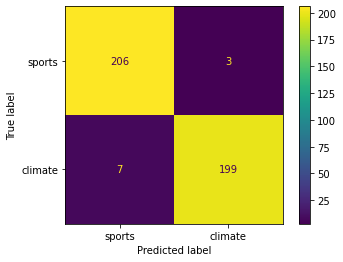

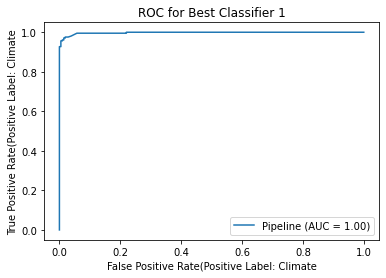

In [1079]:
pipe1 = Pipeline([
    ('count', ftExtNone3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred500),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe1pred = pipe1.predict(test['full_text'])
pipe1Scores = getScores(test_labels, pipe1pred)

print("Scores for Best Classifier 1 : {}\n".format(pipe1['clf']))
print("Accuracy: ", pipe1Scores['accuracy'])
print("Precision: ", pipe1Scores['precision'])
print("Recall Score: ", pipe1Scores['recall'])
print("F1 Score: ", pipe1Scores['f1'])

plot_confusion_matrix(pipe1, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe1, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 1")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

Scores for Best Classifier 2 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.980722891566265
Precision:  0.9900990099009901
Recall Score:  0.970873786407767
F1 Score:  0.9803921568627452


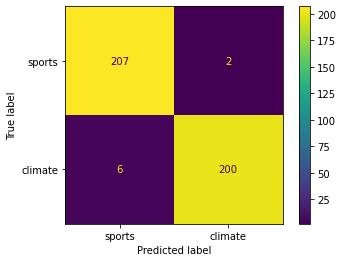

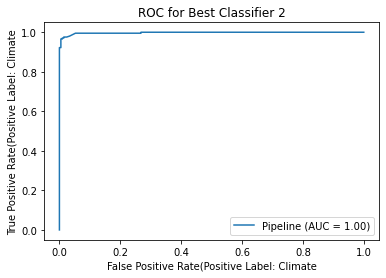

In [1080]:
pipe2 = Pipeline([
    ('count', ftExtStem3NC),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred500),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe2pred = pipe2.predict(test['full_text'])
pipe2Scores = getScores(test_labels, pipe2pred)


print("Scores for Best Classifier 2 : {}\n".format(pipe2['clf']))
print("Accuracy: ", pipe2Scores['accuracy'])
print("Precision: ", pipe2Scores['precision'])
print("Recall Score: ", pipe2Scores['recall'])
print("F1 Score: ", pipe2Scores['f1'])

plot_confusion_matrix(pipe2, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe2, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 2")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

Scores for Best Classifier 3 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.980722891566265
Precision:  0.9900990099009901
Recall Score:  0.970873786407767
F1 Score:  0.9803921568627452


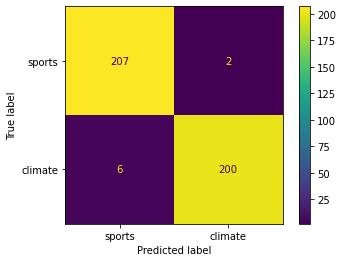

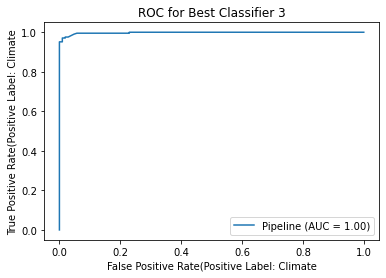

In [1081]:
pipe3 = Pipeline([
    ('count', ftExtNone5),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred500),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe3pred = pipe3.predict(test['full_text'])
pipe3Scores = getScores(test_labels, pipe3pred)


print("Scores for Best Classifier 3 : {}\n".format(pipe3['clf']))
print("Accuracy: ", pipe3Scores['accuracy'])
print("Precision: ", pipe3Scores['precision'])
print("Recall Score: ", pipe3Scores['recall'])
print("F1 Score: ", pipe3Scores['f1'])

plot_confusion_matrix(pipe3, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe3, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 3")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

Scores for Best Classifier 4 : SVC(kernel='linear')

Accuracy:  0.9759036144578314
Precision:  1.0
Recall Score:  0.9514563106796117
F1 Score:  0.9751243781094527


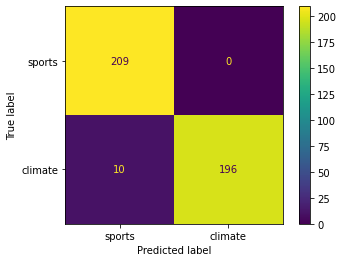

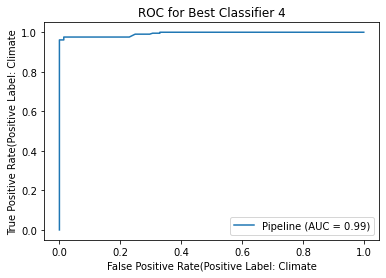

In [1082]:
pipe4 = Pipeline([
    ('count', ftExtNone5),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred500),
    ('clf', clfSVM)
]).fit(train['full_text'], train_labels)

pipe4pred = pipe4.predict(test['full_text'])
pipe4Scores = getScores(test_labels, pipe4pred)



print("Scores for Best Classifier 4 : {}\n".format(pipe4['clf']))
print("Accuracy: ", pipe4Scores['accuracy'])
print("Precision: ", pipe4Scores['precision'])
print("Recall Score: ", pipe4Scores['recall'])
print("F1 Score: ", pipe4Scores['f1'])

plot_confusion_matrix(pipe4, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe4, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 4")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

/Users/gauravsingh/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Scores for Best Classifier 5 : GaussianNB()

Accuracy:  0.9783132530120482
Precision:  0.9852216748768473
Recall Score:  0.970873786407767
F1 Score:  0.9779951100244498


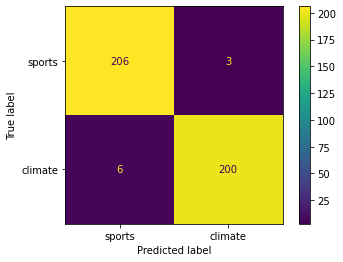

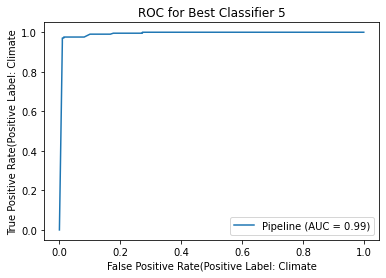

In [1083]:
pipe5 = Pipeline([
    ('count', ftExtStem3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', NMFred50),
    ('clf', clfGaussian)
]).fit(train['full_text'], train_labels)

pipe5pred = pipe5.predict(test['full_text'])
pipe5Scores = getScores(test_labels, pipe5pred)


print("Scores for Best Classifier 5 : {}\n".format(pipe5['clf']))
print("Accuracy: ", pipe5Scores['accuracy'])
print("Precision: ", pipe5Scores['precision'])
print("Recall Score: ", pipe5Scores['recall'])
print("F1 Score: ", pipe5Scores['f1'])

plot_confusion_matrix(pipe5, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe5, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 5")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

## Question 8

The five best combinations based on 'mean_test_score' are given below:

1). <b>Ceaning/ Not Cleaning</b>: Cleaning<br>
    <b>min_df</b> = 3<br>
    <b>Compression</b>: Nothing<br>
    <b>Stop words</b>: True<br>
    <b>Dim Reduction</b>: LSI with 500 components<br>
    <b>Classifier</b>: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')
    
    Accuracy:  0.9759036144578314
    Precision:  0.9851485148514851
    Recall Score:  0.9660194174757282
    F1 Score:  0.9754901960784313
    
    
2). <b>Ceaning/ Not Cleaning</b>: No Cleaning<br>
    <b>min_df</b> = 3<br>
    <b>Compression</b>: Stemming<br>
    <b>Stop words</b>: True<br>
    <b>Dim Reduction</b>: LSI with 500 components<br>
    <b>Classifier</b>: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')
    
    Accuracy:  0.980722891566265
    Precision:  0.9900990099009901
    Recall Score:  0.970873786407767
    F1 Score:  0.9803921568627452
    
3). <b>Ceaning/ Not Cleaning</b>: Cleaning<br>
    <b>min_df</b> = 5<br>
    <b>Compression</b>: Nothing<br>
    <b>Stop words</b>: True<br>
    <b>Dim Reduction</b>: LSI with 500 components<br>
    <b>Classifier</b>: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')
    
    Accuracy:  0.980722891566265
    Precision:  0.9900990099009901
    Recall Score:  0.970873786407767
    F1 Score:  0.9803921568627452
    
4). <b>Ceaning/ Not Cleaning</b>: Cleaning<br>
    <b>min_df</b> = 5<br>
    <b>Compression</b>: Nothing<br>
    <b>Stop words</b>: True<br>
    <b>Dim Reduction</b>: LSI with 500 components<br>
    <b>Classifier</b>: SVC(kernel='linear', C=1.0)
    
    Accuracy:  0.9759036144578314
    Precision:  1.0
    Recall Score:  0.9514563106796117
    F1 Score:  0.9751243781094527
    
    
5). <b>Ceaning/ Not Cleaning</b>: Cleaning<br>
    <b>min_df </b>= 3<br>
    <b>Compression</b>: Stemming<br>
    <b>Stop words</b>: True<br>
    <b>Dim Reduction</b>: NMF with 50 components<br>
    <b>Classifier</b>: GaussianNB()
    
    Accuracy:  0.9783132530120482
    Precision:  0.9852216748768473
    Recall Score:  0.970873786407767
    F1 Score:  0.9779951100244498
    
    
    ***For Top 5 Classifiers the ROC curves and confusinon matrices are plotted above
    
    
    Result: Logistic regression with l1 penalty, regularization parameter = 0.1, solver = 'liblinear', with cleaned data and stemming, along with dim reducition to 500 features using LSI and min_df = 3 comes out to be teh best classifier with accuracy = 0.9807 and F1-score = 0.98

## Multi Class Classification

In [1088]:
# Setting up data

train_leaf_labels = train['leaf_label']
test_leaf_labels = test['leaf_label']

labels = ['chess', 'cricket', 'soccer', 'football', 'forestfire', 'flood', 'earthquake', 'drought']

train_leaf_labels = train_leaf_labels.replace(to_replace=['chess', 'cricket', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought'], value=[0, 1, 2, 3, 4, 5, 6, 7], inplace=False)
test_leaf_labels =  test_leaf_labels.replace(to_replace=['chess', 'cricket', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought'], value=[0, 1, 2, 3, 4, 5, 6, 7], inplace=False)


In [1089]:
# Naive Bayes for Multi Class Classification
NBMulti = GaussianNB()
NBMulti.fit(trainDataK500, train_leaf_labels)

NBMultiPred = NBMulti.predict(testDataK500)

In [1092]:
# One vs All SVM without weights balancing
SVMMulti = svm.SVC(kernel='linear') 
SVMMulti = OneVsRestClassifier(SVMMulti).fit(trainDataK500, train_leaf_labels)

SVMMultiPred = SVMMulti.predict(testDataK500)

In [1093]:
# One vs All SVM with weight balancing

# Better performance with class_weight='balanced'
SVMMultiWB = svm.SVC(kernel='linear', class_weight='balanced') 
SVMMultiWB = OneVsRestClassifier(SVMMultiWB).fit(trainDataK500, train_leaf_labels)

SVMMultiWBPred = SVMMultiWB.predict(testDataK500)

In [1097]:
# One vs One SVM

# Better performance without class_weight='balanced'
SVMMultiOvo = svm.SVC(kernel='linear') 
SVMMultiOvo = OneVsOneClassifier(SVMMultiOvo).fit(trainDataK500, train_leaf_labels)

SVMMultiPredOvo = SVMMultiOvo.predict(testDataK500)

In [1115]:
# Merging football and soccer together 
# Merging forestfire and drought together

train_leaf_labels = train['leaf_label']
test_leaf_labels = test['leaf_label']

labels_NB = ['chess', 'cricket', 'football/soccer', 'fire/drought', 'flood', 'earthquake']

train_leaf_labels_NB = train_leaf_labels.replace(to_replace=['football', 'soccer', '%22forest%20fire%22', 'drought'], value=['football/soccer', 'football/soccer', 'fire/drought', 'fire/drought'], inplace=False)
test_leaf_labels_NB =  test_leaf_labels.replace(to_replace=['football', 'soccer', '%22forest%20fire%22', 'drought'], value=['football/soccer', 'football/soccer', 'fire/drought', 'fire/drought'], inplace=False)
train_leaf_labels_NB = train_leaf_labels_NB.replace(to_replace=['chess', 'cricket', 'football/soccer', 'fire/drought', 'flood', 'earthquake'], value=[0, 1, 2, 3, 4, 5])

test_leaf_labels_NB = test_leaf_labels_NB.replace(to_replace=['chess', 'cricket', 'football/soccer', 'fire/drought', 'flood', 'earthquake'], value=[0, 1, 2, 3, 4, 5])


In [1116]:
NBMultiMerged = GaussianNB()
NBMultiMerged.fit(trainDataK500, train_leaf_labels_NB)

NBMultiMergedPred = NBMultiMerged.predict(testDataK500)

## Question 9


---------Scores for Gaussian Naive Bayes Classifier-------
accuracy: 0.7036144578313253
recall: 0.6999650525300716
precision: 0.8110650142660092
f1_score: 0.7047196239069238

---------Confusion Matrix for Gaussian Naive Bayes Classifier-------


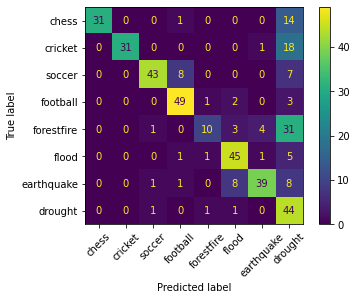


---------Scores for SVM Classifier with ONE VS ALL method-------
accuracy: 0.946987951807229
recall: 0.9466962228321656
precision: 0.9468069611503586
f1_score: 0.9460698103476971

---------Confusion Matrix for ONE VS ALL SVM Classifier-------


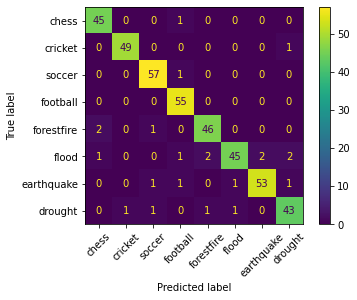

In [1095]:
# Plotting confusion matrix 

print("\n---------Scores for Gaussian Naive Bayes Classifier-------")
print('accuracy:', accuracy_score(test_leaf_labels, NBMultiPred))
print('recall:', recall_score(test_leaf_labels, NBMultiPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, NBMultiPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, NBMultiPred, average='macro'))

print("\n---------Confusion Matrix for Gaussian Naive Bayes Classifier-------")
plot_confusion_matrix(NBMulti, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

print("\n---------Scores for SVM Classifier with ONE VS ALL method-------")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiPred))
print('recall:', recall_score(test_leaf_labels, SVMMultiPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiPred, average='macro'))

print("\n---------Confusion Matrix for ONE VS ALL SVM Classifier-------")
plot_confusion_matrix(SVMMulti, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()



---------Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)-------
accuracy: 0.9397590361445783
recall: 0.9396266847758646
precision: 0.9398305163582473
f1_score: 0.9387947345142014

---------Confusion Matrix for ONE VS ALL SVM Classifier(with Weight Balancing)-------


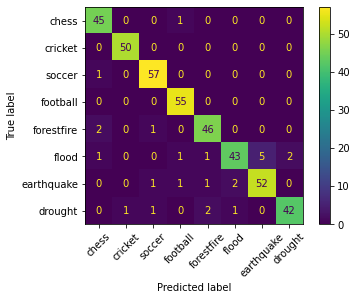


---------Scores for SVM Classifier with ONE VS ONE method-------
accuracy: 0.9204819277108434
recall: 0.921118579473643
precision: 0.9220062690062201
f1_score: 0.9199552861430096

---------Confusion Matrix for ONE VS ONE SVM Classifier-------


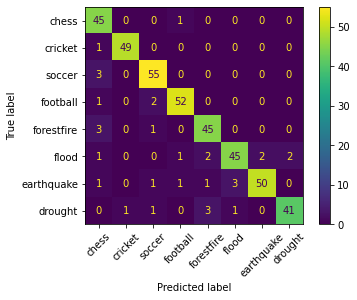

In [1096]:
print("\n---------Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)-------")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiWBPred))
print('recall:', recall_score(test_leaf_labels, SVMMultiWBPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiWBPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiWBPred, average='macro'))

print("\n---------Confusion Matrix for ONE VS ALL SVM Classifier(with Weight Balancing)-------")
plot_confusion_matrix(SVMMultiWB, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

print("\n---------Scores for SVM Classifier with ONE VS ONE method-------")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiPredOvo))
print('recall:', recall_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))


print("\n---------Confusion Matrix for ONE VS ONE SVM Classifier-------")
plot_confusion_matrix(SVMMultiOvo, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()


---------Scores for Gaussian NB Over merged data-------
accuracy: 0.7734939759036145
recall: 0.7921984736817483
precision: 0.8346857762745393
f1_score: 0.7807920944229972

---------Confusion Matrix for Gaussian NB Over merged data-------


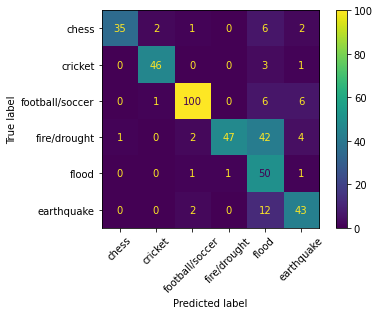

In [1117]:
#  Scores for Gaussian NB after merging classes together.
print("\n---------Scores for Gaussian NB Over merged data-------")
print('accuracy:', accuracy_score(test_leaf_labels_NB, NBMultiMergedPred))
print('recall:', recall_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))
print('precision:', precision_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))

print("\n---------Confusion Matrix for Gaussian NB Over merged data-------")
plot_confusion_matrix(NBMultiMerged, testDataK500, test_leaf_labels_NB, display_labels=labels_NB, xticks_rotation=45)
plt.show()

<b>a).</b>
The confusion matrices for Multi Class SVM Classifier with ONE VS REST (with and without weight balancing )and ONE VS ONE, Gaussian Naive Bayes classifier are plotted above.

One vs Rest in general faces class imbalance issue because while training One vs Rest, one of the n classes are treates as positives and all other n-1 classes are treated as negatives. Thus negatives predominate in the dataset with more samples. This imbalance in classes can be treated by using <b>weight balancing</b> where minority class data samples are given higher wieghts (C values) so that their misclassification is penalized more, and majority classes are given lower C values. <br>
This can be done using <b>class_weight='balanced'</b> in Scikit learns SVC.

<b>Scores for Gaussian Naive Bayes Classifier</b><br>
accuracy: 0.7036144578313253<br>
recall: 0.6999650525300716<br>
precision: 0.8110650142660092<br>
f1_score: 0.7047196239069238


<b>Scores for SVM Classifier with ONE VS ALL method</b><br>
accuracy: 0.946987951807229<br>
recall: 0.9466962228321656<br>
precision: 0.9468069611503586<br>
f1_score: 0.9460698103476971

<b>Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)</b><br>
accuracy: 0.9397590361445783<br>
recall: 0.9396266847758646<br>
precision: 0.9398305163582473<br>
f1_score: 0.9387947345142014<br>


<b>Scores for SVM Classifier with ONE VS ONE method</b><br>
accuracy: 0.9204819277108434<br>
recall: 0.921118579473643<br>
precision: 0.9220062690062201<br>
f1_score: 0.9199552861430096<br>

Gaussian Naive Bayes performs bad compared to SVM. 

SVM perform good on all classes as we can see there are not much False Positives or False negatives in any specific sub class as such as seen in the confusion matrices of all SVM's scores and confusion matrices above.

But Gaussian Naive Bayes performs bad and this is evident from its confusion matrix.

It's predicting <b>soccer</b> as <b>football</b> in nearly 8 of the test samples. Also there are a lot of misclassifications on class <b>forestfire</b> where most of the <b>forestfire</b> is predicted as <b>drought</b>.

This can somewhat be improved by merging <b>football and soccer in a single class as football/soccer</b> and <b>forestfire and drought can be merged together as fire/drought</b>.

For SVM the results are quite nice, there are no such heavy misclassifications and there is not need to merge any two subclasses together and do ONE VS ALL and ONE VS ONE Strategy as such.

But this the above observed trend for Gaussian Naive Bayes is implemented and results are as follows:<br>
<b>Scores for Gaussian NB Over merged data</b>

accuracy: 0.7734939759036145<br>
recall: 0.7921984736817483<br>
precision: 0.8346857762745393<br>
f1_score: 0.7807920944229972<br>

** The confusion matrix for Gaussian NB Over merged data is plotted above. Clearly we can see that there is a good resolution among sports subclasses but the <b>climate related articles are not well classified by Gaussian NB.</b>

<b>Using the above merge strategy I am able to increase the accuracy by ~8 percent, and F1-score by ~9 percent.<b>

### Question 10

<b>(a)</b>. GLoVE embeddings are trained on the ratio of co-occurence probabilitites rather than the probabilities       themselves because it gives a better relation on how a given word is closely related to other two baseline words. It gives better concrete relationship between a word's coherence with other words and penalizes the unrelated words more. Also it helps in mapping the related words in the dimension space farther thus providing better resolution. The related words gives higher/lower absolute scores compared to unrelated contextual words which get scores close to 1. 

<b>(b)</b>. There are two cases to consider.
     - If the corpus is containing these two sentences together then "running" will have same GLoVE embedding.
     - If there are two corpus. One corpus having only first sentence - "James is running in the park" and other having only other given sentence - "James is running for the presidency" will give us the same embeddings for word "running" given the number of words are exactly same for both corpuses and the relatve ordering is quite same, and there are no other sentences to get co-occurence probabilitites of other words which can change the co-occurence ratios, and thus there is no change in the space which they occupy in dimension space.
     

<b>(c)</b>. || Glove["queen"] - Glove["king"] - Glove["wife"] + Glove["husband"] || this should be close to zero. Given the fact that the embeddings are such that they preserve the context in between words in the form of vector differences and the analogous difference between a king and queen is very similar to that of a husband and wife

Also,
|| Glove["queen"] - Glove["king"]|| = || Glove["wife"] + Glove["husband"] ||, because ideally in the vector space containing these words, and given that corpus was large enough to train GLoVE such that the contextual meanings with respect to other words are captured well then, the relative difference between queen and king vector equals the relative difference between wife and king husband vector.

<b>(d)</b>. Depends on how the GLoVE is implemented. Let's say one building a GLoVE model, on one's own corpus and before building it the whole corpus is lemmatized/stemmed then, at testing time or for later uses, one needs to lemmatize the words to get the embeddings. If the GLoVE model was not trained on lemmatized/ stemmed corpus one can get the embeddings directly.

Also, given that let's say GLoVE has all words in the universal vocabulary, like all the lemmatized/stemmed words and normal words as well, then one should go with extracting the lemmaztized/ stemmed words from embeddings, if the training data is not too much because then without lemmatization/stemming the data will be too sparse.


## Using GLoVE Embeddings

In [711]:
#  Loading GLoVE embeddings.
embeddings_dict = {}
dimension_of_glove = 300
with open("./glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [889]:
# Processing pipeline for GLoVE based embeddings
"""
1). Same preprocessing for each news article along with manual removal of stopwords.
2). Converting each document ['full_text'] to a vector representation using the sum of all
    word embeddings in the document. If a word is not in embeddings we will skip it.
3). Since embeddings are of size 300, we would be reducing it to some K using LSI to retain the most variance.
4). Will use different classifiers to evaluate the results.
"""
def preprocessingGlove(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [removeStopwords(nltk.word_tokenize(sentence), stopWords) for sentence in sample]
    sample = [lemmatize(sentence) for sentence in sample]
    sample = " ".join(sample)
    return sample

def removeStopwords(words, stopWords):
    return " ".join([word for word in words if word not in stopWords])

def getDocEmbeddings(doc, embeddings_dict=embeddings_dict):
    embedding_size = len(embeddings_dict['the'])
    words = nltk.word_tokenize(preprocessingGlove(doc))
    count = len(words)
    vector = np.zeros(embedding_size)
    
    for word in words:
        if word in embeddings_dict:
            vector = vector + np.array(embeddings_dict[word])
    
    return (vector/np.linalg.norm(vector, 2))

# Assumes climate as 1.
def getTrainTestEmbeddings(train, test, embeddings_dict=embeddings_dict):
    x_train = np.array([getDocEmbeddings(doc, embeddings_dict) for doc in train['full_text']])
    y_train = (train['root_label'] == 'climate').astype('int')

    x_test = np.array([getDocEmbeddings(doc, embeddings_dict) for doc in test['full_text']])
    y_test = (test['root_label'] == 'climate').astype('int')
    return x_train, y_train, x_test, y_test

In [837]:
# Getting testing and training Glove embeddings based data
x_train_glove, y_train_glove, x_test_glove, y_test_glove = getTrainTestEmbeddings(train, test, embeddings_dict)

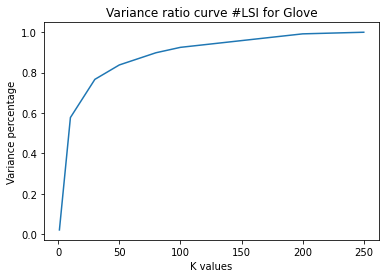

In [842]:
k_values_glove = [1, 10, 30, 50, 80, 100, 200, 250]
variance_ratio_glove = []
reconstructionErrorsGlove = []

for i in range(0, len(k_values_glove)):
    SVD = getSVD(k_values_glove[i], x_train_glove)
    variance_ratio_glove.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(x_train_glove)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrorsGlove.append(np.linalg.norm((x_train_glove - reconstruct), 'fro') ** 2)
    
plt.plot(k_values_glove, variance_ratio_glove)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI for Glove")
plt.show()

## Question 11.

<b>(a).</b><br>

<b>Feature Engineering process:</b>

- Same pre-processing as I did earlier, for the TF-IDF on the "full-text" feature. Cleaning involves, removal of HTML artifacts, removal of punctuations, removal of numbers, stripping eextra spaces, expanding the shortform of words, removal of stopwords using nltk corpus and lemmatization of each document.

- Then we are loading a 300 dimensional GLoVE embeddings dictionary, converting each cleaned document ['full_text'] to a vector representation using the sum of all word embeddings in the document and then normalizing it, thus the resulting vecotr is of size 300 representing each document. If a word is not in embeddings I am skipping it.

- One other possible way to achieve the document embeddings is that we can get the TF-IDF scores of words in the whole corpus. These TF-IDF scores can then be used to represent the document vector as a weighted sum word embeddings in a document. like: <b>document_embedding = normalize(sum_of_all_words(TF-IDF score of word * glove_embedding[word]))</b>.

- Since embeddings are of size 300, we would be reducing it to some K using LSI and explained variance ratio analysis to retain the most variance so that the curse of dimensionality has reduced effect.

- Will use different classifiers to evaluate the results.

In [859]:
# Evaluating model on all of data with 300 features.

# Using the best SVM and Logistic classifier that we found from GridSearchCV 
bestlogisticGlove = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
bestlogisticGlove.fit(x_train_glove, y_train_glove)
bestlogisticGlovePred = bestlogisticGlove.predict(x_test_glove)

bestSVMGlove = svm.SVC(kernel='linear')
bestSVMGlove.fit(x_train_glove, y_train_glove)
bestSVMGlovePred = bestSVMGlove.predict(x_test_glove)

Scores for Best Logistic Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.963855421686747

Precision:  0.9948186528497409

Recall Score:  0.9320388349514563

F1 Score:  0.9624060150375939


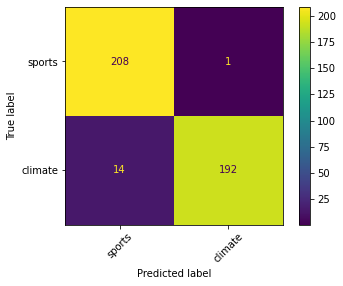

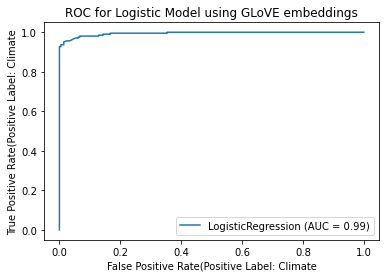



Scores for Best SVM Classifier: SVC(kernel='linear') 

Accuracy:  0.9518072289156626

Precision:  1.0

Recall Score:  0.9029126213592233

F1 Score:  0.9489795918367347


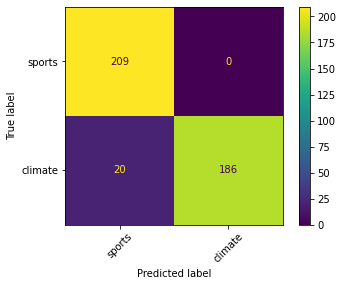

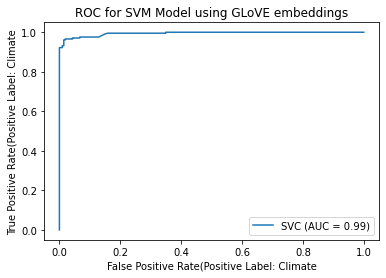

In [871]:
print("Scores for Best Logistic Classifier: {}\n".format(bestlogisticGlove))
print("Accuracy: ", getScores(y_test_glove, bestlogisticGlovePred)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestlogisticGlovePred)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestlogisticGlovePred)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestlogisticGlovePred)['f1'])

plot_confusion_matrix(bestlogisticGlove, x_test_glove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestlogisticGlove, x_test_glove, y_test_glove)
plt.title("ROC for Logistic Model using GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

print("\n\nScores for Best SVM Classifier: {} \n".format(bestSVMGlove))
print("Accuracy: ", getScores(y_test_glove, bestSVMGlovePred)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestSVMGlovePred)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestSVMGlovePred)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestSVMGlovePred)['f1'])

plot_confusion_matrix(bestSVMGlove, x_test_glove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestSVMGlove, x_test_glove, y_test_glove)
plt.title("ROC for SVM Model using GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


In [882]:
# 50 dimensional GLoVE features seems to be a good fit giving reconstruction error of around 70.65 and variance of about 80%

glove_dim = 50

SVD = getSVD(glove_dim, x_train_glove)
x_train_transGlove = SVD.transform(x_train_glove)
x_test_transGlove = SVD.transform(x_test_glove)

# Logistic classifier on LSI reduced GLoVE features
bestlogisticGlove2 = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
bestlogisticGlove2.fit(x_train_transGlove, y_train_glove)
bestlogisticGlovePred2 = bestlogisticGlove2.predict(x_test_transGlove)

# SVM classifier on LSI reduced GLoVE features
bestSVMGlove2 = svm.SVC(kernel='linear')
bestSVMGlove2.fit(x_train_transGlove, y_train_glove)
bestSVMGlovePred2 = bestSVMGlove2.predict(x_test_transGlove)


Scores for Best Logistic Classifier on 50 LSI reduced embeddings: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9686746987951808

Precision:  0.9948717948717949

Recall Score:  0.941747572815534

F1 Score:  0.9675810473815462


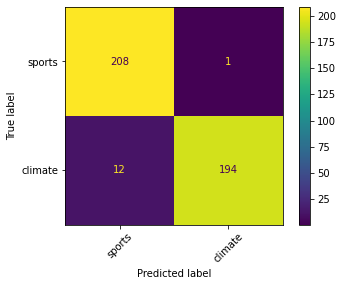

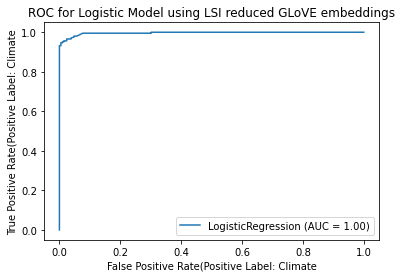



Scores for Best SVM Classifier on 50 LSI reduced embeddings: SVC(kernel='linear') 

Accuracy:  0.9590361445783132

Precision:  0.9947643979057592

Recall Score:  0.9223300970873787

F1 Score:  0.9571788413098237


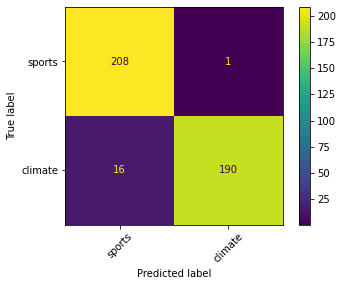

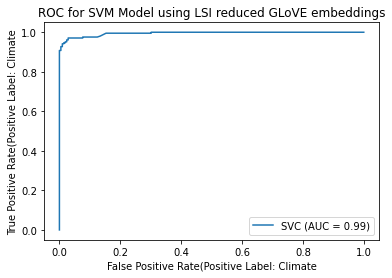

In [884]:
# Getting scores of two best classifiers on reduced dimensions.

print("Scores for Best Logistic Classifier on 50 LSI reduced embeddings: {}\n".format(bestlogisticGlove2))
print("Accuracy: ", getScores(y_test_glove, bestlogisticGlovePred2)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestlogisticGlovePred2)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestlogisticGlovePred2)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestlogisticGlovePred2)['f1'])

plot_confusion_matrix(bestlogisticGlove2, x_test_transGlove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestlogisticGlove2, x_test_transGlove, y_test_glove)
plt.title("ROC for Logistic Model using LSI reduced GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

print("\n\nScores for Best SVM Classifier on 50 LSI reduced embeddings: {} \n".format(bestSVMGlove2))
print("Accuracy: ", getScores(y_test_glove, bestSVMGlovePred2)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestSVMGlovePred2)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestSVMGlovePred2)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestSVMGlovePred2)['f1'])

plot_confusion_matrix(bestSVMGlove2, x_test_transGlove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestSVMGlove2, x_test_transGlove, y_test_glove)
plt.title("ROC for SVM Model using LSI reduced GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


<b>(b).</b><br>

From above results we see the 50 dimension reduced GLoVE embeddings perform best with Logistic Classifier with best overall accuracy on test set along with least False positives and False Negatives.

<b>ROC Curves and Confusion Matrices for Logistic regression and SVM classifier are given above.</b>

<b>Two methods were used, one where all of the dimensions from embeddings are used and other where only 50 LSI reduced features were used.</b>

***50*** dimensional GLoVE features seemed to be a good fit giving MSE reconstruction error of around ***70.65*** and variance of about ***80%***



***(Using all 300 dimensions) Scores for Best Logistic Classifier on test data: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')***

Accuracy:  0.963855421686747

Precision:  0.9948186528497409

Recall Score:  0.9320388349514563

F1 Score:  0.9624060150375939

***(Using all 300 dimensions)Scores for Best SVM Classifier on test data: SVC(kernel='linear') ***

Accuracy:  0.9518072289156626

Precision:  1.0

Recall Score:  0.9029126213592233

F1 Score:  0.9489795918367347


***Scores for Best Logistic Classifier on 50 LSI reduced embeddings: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')***

Accuracy:  0.9686746987951808

Precision:  0.9948717948717949

Recall Score:  0.941747572815534

F1 Score:  0.9675810473815462


***Scores for Best SVM Classifier on 50 LSI reduced embeddings: SVC(kernel='linear') ***

Accuracy:  0.9590361445783132

Precision:  0.9947643979057592

Recall Score:  0.9223300970873787

F1 Score:  0.9571788413098237


***I used Logistic and SVM classifier as earlier I found that for the similar type problem using TF-IDF, these came out to be best from GridSearchCV, this doesn't proof anything that I should be using these classifiers here as well since the data is completely changed but the results seem quite compelling as stated above with accuracies of >95%***

Also its shown that reduced feature embeddings using LSI seems to improve a little bit of performance, given the False Positives and False negatives are both reduced when using reduced dimensions. Also the scores for both SVM and Logistic Regression have ben increased by <b>~1%</b>.

The best performance achieved using GLoVE embeddings is around : ***96.86% accuracy with F1-score of 0.967 using Logistic regression with parameters (C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')***

### Using different length embeddings and its effect on classifier performance

I am using the Logistic classifier as the classifier to investigate the effect of changes in the dimension of pre-trained GLoVE embeddings on the resulting accuacy of the model.

In [896]:
fileNames = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']

accuracies = []
precisions = []
recalls = []
f1s = []

for file in fileNames:
    embeddings_dict = {}
    fpath = "./glove.6B/{}".format(file)
    with open(fpath, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    x_tr_glove, y_tr_glove, x_te_glove, y_te_glove = getTrainTestEmbeddings(train, test, embeddings_dict)
    
    logModel = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
    logModel.fit(x_tr_glove, y_tr_glove)
    logModelPreds = logModel.predict(x_te_glove)
    
    logScores = getScores(y_te_glove, logModelPreds)
    accuracies.append(logScores['accuracy'])
    precisions.append(logScores['precision'])
    recalls.append(logScores['recall'])
    f1s.append(logScores['f1'])

Text(0.5, 1.0, 'Performance measure of Logistic Classifier on different dimensional GLoVE embeddings')

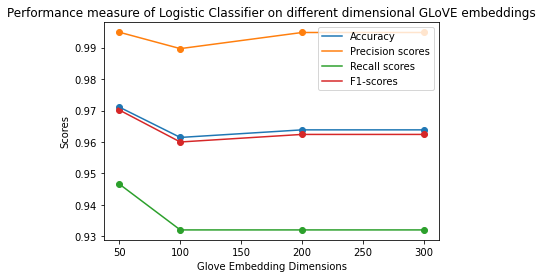

In [1118]:
# Plotting the graphs to see the differences in model performance with change in GLoVE embedding dimensions

glove_K = [50, 100, 200, 300]

plt.xlabel("Glove Embedding Dimensions")
plt.ylabel("Scores")

plt.scatter(glove_K, accuracies)
plt.plot(glove_K, accuracies)

plt.scatter(glove_K, precisions)
plt.plot(glove_K, precisions)

plt.scatter(glove_K, recalls)
plt.plot(glove_K, recalls)

plt.scatter(glove_K, f1s)
plt.plot(glove_K, f1s)

plt.legend(["Accuracy", "Precision scores", "Recall scores", "F1-scores"], loc="best")
plt.title("Performance measure of Logistic Classifier on different dimensional GLoVE embeddings")

## Question 12

The relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task is plotted above.

The model used for studying this effect is Logistic Regression with l1 penalty which gave the best results previously.

The trend observed from above plot is that, as the number of dimensions (features) are increased, the accuracy is decreased, and after that the changes are quite negligible.

This trend was expected because as the number of features are increased the number of training samples should be increased as well to result in the same or better performance when more information is captured in the form of new features. But this is not the case here, the no. of training samples are fixed and hence model's performance is decreased. 
Also since the classifier is Logistic regression this trend was expected more, since SVM generally have less effect of curse of dimensionality on them since they use Kernel trick.

## Question 13
### Plotting train data from GLoVE using UMAP (dimensions = 300)

As we can see rom below plot, there are two almost separable clusters formed. One represents the climate data samples and other the sports samples. Since they are quite well separated we are expected to get good performance of models which is evident from above metrics using different classifiers giving around ***>95% accuracy.***

Also we can see that almost well separated clusters are formed representing the subclasses of the news articles in the plot below.

There is some overlapping in clusters which can be covered using non-linear decision boundaries. Thus a good performance is expected from classifiers on this sort of data representation using GLoVE embeddings.

For the next plot where I am plotting random normalized vectors of same dimension as the GLoVE embeddings i.e. 300, the labels are randomly allocated to each of 1657 randomly generated samples but <b>no clear clusters can be seen</b> this implies that some sort of ordering has to be there and that every data under consideration of ML follows some distribution so that it can be classified.

Text(0.5, 1.0, 'Data visualisation on Root label level using UMAP(300 to 2 dim reduction)')

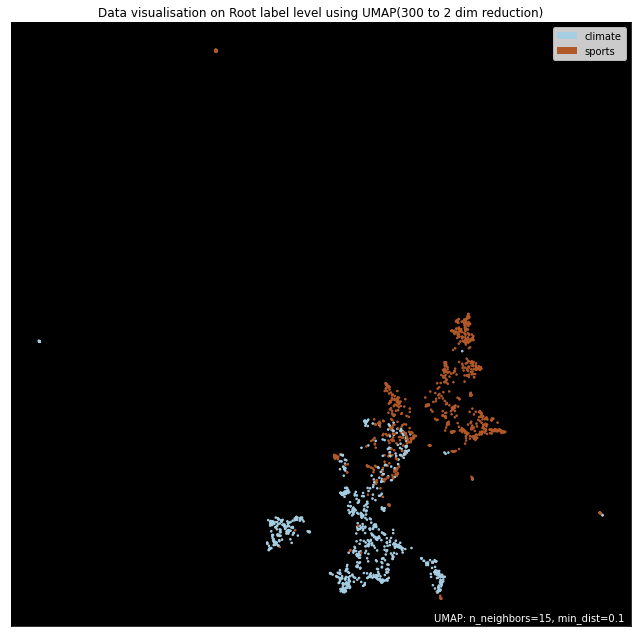

In [1119]:
mapper = umap.UMAP().fit(x_train_glove)
labs = np.array(['climate' if label == 1 else 'sports' for label in y_train_glove])
umap.plot.points(mapper, labels=labs, color_key_cmap='Paired', background='black')
plt.title("Data visualisation on Root label level using UMAP(300 to 2 dim reduction)")

Text(0.5, 1.0, 'Data visualisation on Leaf label level using UMAP(300 to 2 dim reduction)')

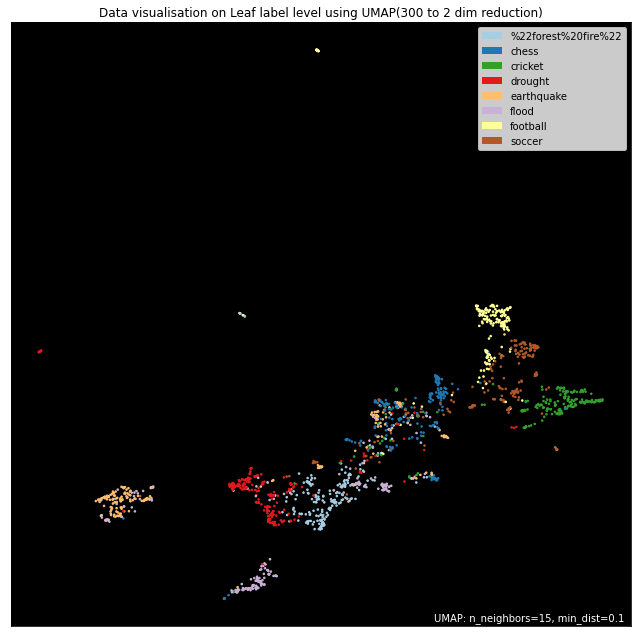

In [977]:
mapper = umap.UMAP().fit(x_train_glove)
umap.plot.points(mapper, labels=train['leaf_label'], color_key_cmap='Paired', background='black')
plt.title("Data visualisation on Leaf label level using UMAP(300 to 2 dim reduction)")

Text(0.5, 1.0, 'Plotting random High dimensional data same as Glove with 10 random labels on 2-D plot')

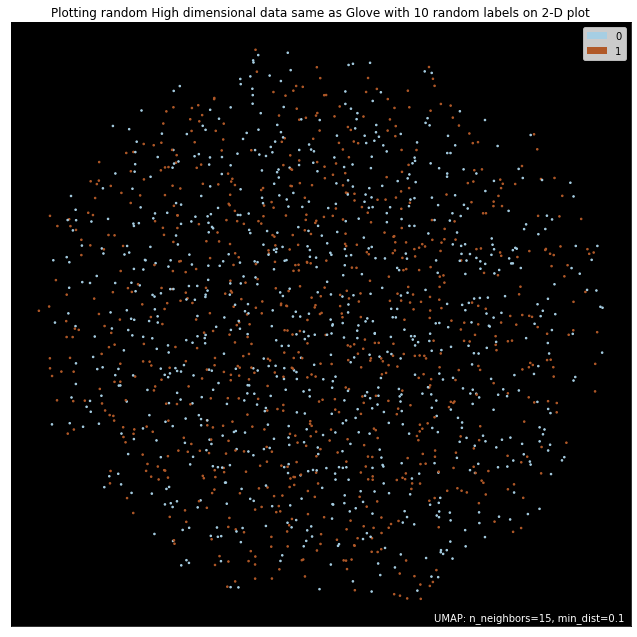

In [1129]:
# Generating random normalized data and plotting it using UMAP.
rows = x_train_glove.shape[0]
cols = x_train_glove.shape[1]
randomLabels = np.random.randint(0, 2, rows, dtype=int)
randomVecs = np.random.rand(rows, cols)
for i in range(len(randomVecs)):
    randomVecs[i] = randomVecs[i]/np.linalg.norm(randomVecs[i], 2)
    
mapper = umap.UMAP().fit(randomVecs)
umap.plot.points(mapper, labels=randomLabels, color_key_cmap='Paired', background='black')

plt.title("Plotting random High dimensional data same as Glove with 10 random labels on 2-D plot")